In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 46 kB/s 
     |████████████████████████████████| 199 kB 57.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f86f23aab02657ed415c91a870b429c99ce35b57026f6299f8c274fb282826f5
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
import collections
from pandas import DataFrame
from scipy.cluster.hierarchy import linkage, dendrogram

from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SQLContext, Row

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt 

%matplotlib inline

In [ ]:
# personality scores
data1 = pd.read_excel('/pers_scores.xlsx')
# articles by some traveler
data2 = pd.read_excel('/articles.xlsx')
# traveler profile
data3 = pd.read_excel('/users.xlsx')
# traveler and reviews
data4 = pd.read_excel('/reviews_of_users.xlsx')

In [ ]:
data1.head(10)

,username,open,cons,extra,agree,neuro
0,007solotraveler,0.63272,0.55666,0.56360,0.58108,0.45881
1,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188
2,10179k79,0.66435,0.56099,0.56880,0.58187,0.45011
3,124_10,0.66003,0.57005,0.57221,0.59019,0.44860
4,12ReasonsWhy,0.65036,0.55429,0.56510,0.58271,0.45919
5,14beacon,0.64359,0.56584,0.56965,0.59001,0.45454
6,150NightsPerYear,0.64723,0.56101,0.56812,0.58680,0.45754
7,1771,0.64250,0.56661,0.56833,0.58737,0.45630
8,186402Sarah1984,0.64739,0.55803,0.56643,0.58308,0.45631
9,1969ws,0.63786,0.56099,0.56748,0.58927,0.45958


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  1098 non-null   object 
 1   open      1098 non-null   float64
 2   cons      1098 non-null   float64
 3   extra     1098 non-null   float64
 4   agree     1098 non-null   float64
 5   neuro     1098 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.6+ KB


In [ ]:

data2.head(5)

,username,date,title,text,total_points
0,19katy80,2012-07-15,Why come to Manchester?,"Quite simply, whatever your interest, Manchest...",5
1,29grapes,2010-03-27,Taxis in Shanghai,Taxi companies in Shanghai are heavily regulat...,5
2,ALiEN2108,2011-11-03,Arriving & Departing,Airport Transfer FAQs answered:\nThere are two...,5
3,ASK_THE_LEYLANDS,2010-11-09,"HEYSEN AND MAWSON TRAILS, AUSTRALIA",Laura is small township situated in the Sout...,100
4,Alfanumeric,2013-12-06,Neighborhoods,City Centre\nWhile Americans cousins refer to ...,5


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   username      159 non-null    object        
 1   date          159 non-null    datetime64[ns]
 2   title         159 non-null    object        
 3   text          159 non-null    object        
 4   total_points  159 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ KB


In [ ]:
data3.head(5)

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,007solotraveler,35-49,male,liverpool,NaN,Contributor,2010-06-01,10.0,1.0,1.0,NaN,6.0,NaN,NaN,NaN,8.0,1240.0,3,10
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
2,1010101,NaN,NaN,uk,NaN,NaN,2009-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
3,10179k79,NaN,NaN,"Berlin, Germany",NaN,Top Contributor,2008-05-01,54.0,1.0,NaN,3.0,2.0,8.0,NaN,NaN,48.0,5808.0,5,58
4,10onwoodford,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7034 entries, 0 to 7033
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   username           7034 non-null   object        
 1   ageRange           4786 non-null   object        
 2   gender             5299 non-null   object        
 3   location           6831 non-null   object        
 4   travelStyle        3502 non-null   object        
 5   reviewerBadge      6948 non-null   object        
 6   registerDate       6953 non-null   datetime64[ns]
 7   numHotelsReviews   6945 non-null   float64       
 8   numRestReviews     5882 non-null   float64       
 9   numAttractReviews  4870 non-null   float64       
 10  numFirstToReview   5196 non-null   float64       
 11  numRatings         4513 non-null   float64       
 12  numPhotos          3676 non-null   float64       
 13  numForumPosts      2601 non-null   float64       
 14  numArtic

In [ ]:
data4.head(5)

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,1,007solotraveler,Hotels,2013-04-08,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
1,2,007solotraveler,Hotels,2013-04-08,Modern and Chic - suitable both family and bus...,Excellent Hotel - well situated for getting ro...,5,0.0,100,Radisson Blu Waterfront Hotel,http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm
2,3,007solotraveler,Attractions,2013-02-20,Brilliant - Well worth a visit(s),Great Museum - abslutely worth making the time...,5,1.0,101,Vasa Museum,http://www.tripadvisor.com/Attraction_Review-g...,Stockholm
3,4,007solotraveler,Hotels,2012-07-09,Family stay,Stayed for 3 nights in MIami - stayed here due...,4,0.0,100,Hilton Miami Airport,http://www.tripadvisor.com/Hotel_Review-g34438...,Miami
4,5,007solotraveler,Restaurants,2011-09-07,Great Prime Rib!,I always visit Hunters when in San Diego. The ...,5,1.0,101,Hunter Steakhouse,http://www.tripadvisor.com/Restaurant_Review-g...,San Diego


In [ ]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32580 entries, 0 to 32579
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            32580 non-null  int64         
 1   username      32580 non-null  object        
 2   type          32580 non-null  object        
 3   date          32580 non-null  datetime64[ns]
 4   title         32580 non-null  object        
 5   text          32579 non-null  object        
 6   rating        32580 non-null  int64         
 7   helpfulness   24105 non-null  float64       
 8   total_points  32580 non-null  int64         
 9   taObject      32580 non-null  object        
 10  taObjectUrl   32580 non-null  object        
 11  taObjectCity  32580 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 3.0+ MB


# Exploratory Data Analysis

**Data-3(users)
-data3 with total tripadvisor point > 1000 and no null age or gender**

In [ ]:
nullage = data3.ageRange.isnull()
nullgender = data3.gender.isnull()
nullstyle = data3.travelStyle.isnull()

In [ ]:

filtered_data3 = data3[data3.totalPoints > 1000][~nullage][~nullgender][~nullstyle]
filtered_data3.head()

<ipython-input-134-4ce4ba12b6f9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data3 = data3[data3.totalPoints > 1000][~nullage][~nullgender][~nullstyle]


,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14
12,1975mark,25-34,male,"Huddersfield, United Kingdom","Foodie, Beach Goer, Thrifty Traveller, Nightli...",Senior Contributor,2010-06-01,12.0,15.0,NaN,4.0,NaN,NaN,NaN,NaN,13.0,2718.0,4,18
15,19Cam,25-34,male,"London, United Kingdom","Vegetarian, Urban Explorer, Art and Architectu...",Top Contributor,2010-05-01,58.0,28.0,8.0,NaN,2.0,12.0,1.0,NaN,49.0,9836.0,5,46
17,1Angie,18-24,female,"Melbourne, Australia","Beach Goer, Vegetarian, Urban Explorer",Senior Contributor,2010-08-01,20.0,5.0,8.0,3.0,NaN,11.0,NaN,NaN,18.0,3649.0,4,19


In [ ]:

filtered_data3.shape

(2523, 19)

**creating new column of list of travel style**

In [ ]:
data3_test = filtered_data3
style_lst2 = [item.split(', ') for item in data3_test.travelStyle]
style_lst2
data3_test.shape

(2523, 19)

In [ ]:
data3_test['new_travel'] = style_lst2
data3_test
#new_travel column is created

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes,new_travel
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12,"[Foodie, Nature Lover, Urban Explorer]"
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14,"[Foodie, Trendsetter, Like a Local, Luxury Tra..."
12,1975mark,25-34,male,"Huddersfield, United Kingdom","Foodie, Beach Goer, Thrifty Traveller, Nightli...",Senior Contributor,2010-06-01,12.0,15.0,NaN,4.0,NaN,NaN,NaN,NaN,13.0,2718.0,4,18,"[Foodie, Beach Goer, Thrifty Traveller, Nightl..."
15,19Cam,25-34,male,"London, United Kingdom","Vegetarian, Urban Explorer, Art and Architectu...",Top Contributor,2010-05-01,58.0,28.0,8.0,NaN,2.0,12.0,1.0,NaN,49.0,9836.0,5,46,"[Vegetarian, Urban Explorer, Art and Architect..."
17,1Angie,18-24,female,"Melbourne, Australia","Beach Goer, Vegetarian, Urban Explorer",Senior Contributor,2010-08-01,20.0,5.0,8.0,3.0,NaN,11.0,NaN,NaN,18.0,3649.0,4,19,"[Beach Goer, Vegetarian, Urban Explorer]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,zohei,50-64,male,"Paris, France","Foodie, Like a Local, Urban Explorer, Luxury T...",Top Contributor,2005-11-01,33.0,42.0,1.0,13.0,1.0,36.0,NaN,NaN,28.0,8731.0,5,46,"[Foodie, Like a Local, Urban Explorer, Luxury ..."
7028,zotar,35-49,male,UK,"Foodie, Like a Local, Urban Explorer, Family H...",Top Contributor,2006-08-01,28.0,47.0,5.0,10.0,14.0,NaN,33.0,NaN,47.0,8809.0,5,79,"[Foodie, Like a Local, Urban Explorer, Family ..."
7029,zsazsa-stl,35-49,female,"Baltimore, Maryland","Like a Local, Thrifty Traveller, Art and Archi...",Top Contributor,2006-03-01,24.0,34.0,12.0,6.0,15.0,NaN,20.0,NaN,37.0,7499.0,5,24,"[Like a Local, Thrifty Traveller, Art and Arch..."
7031,zulnas,35-49,male,"Singapore, Singapore","Foodie, Thrifty Traveller, Shopping Fanatic",Top Contributor,2006-05-01,38.0,5.0,15.0,12.0,79.0,55.0,40.0,NaN,41.0,8678.0,5,33,"[Foodie, Thrifty Traveller, Shopping Fanatic]"


**creating dummies for each travel style**

In [ ]:
travel_style = data3_test['new_travel'].apply(pd.Series)
travel_style_matrix = pd.get_dummies(travel_style.apply(pd.Series).stack()). \
sum(level=0).rename(columns = lambda x : 'travel_style_' + x)

<ipython-input-138-9ae2dac8d28b>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  travel_style_matrix = pd.get_dummies(travel_style.apply(pd.Series).stack()). \


In [ ]:
travel_style_matrix

,travel_style_60+ Traveler,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,travel_style_Eco-tourist,travel_style_Family Hoilday Maker,travel_style_Foodie,travel_style_History Buff,travel_style_Like a Local,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
7,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0
12,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0
7028,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0
7029,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
7031,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [ ]:
travel_style_matrix.columns

Index(['travel_style_60+ Traveler', 'travel_style_Art and Architecture Lover',
       'travel_style_Backpacker', 'travel_style_Beach Goer',
       'travel_style_Eco-tourist', 'travel_style_Family Hoilday Maker',
       'travel_style_Foodie', 'travel_style_History Buff',
       'travel_style_Like a Local', 'travel_style_Luxury Traveller',
       'travel_style_Nature Lover', 'travel_style_Nightlife Seeker',
       'travel_style_Peace and Quiet Seeker', 'travel_style_Shopping Fanatic',
       'travel_style_Thrifty Traveller', 'travel_style_Thrill Seeker',
       'travel_style_Trendsetter', 'travel_style_Urban Explorer',
       'travel_style_Vegetarian'],
      dtype='object')

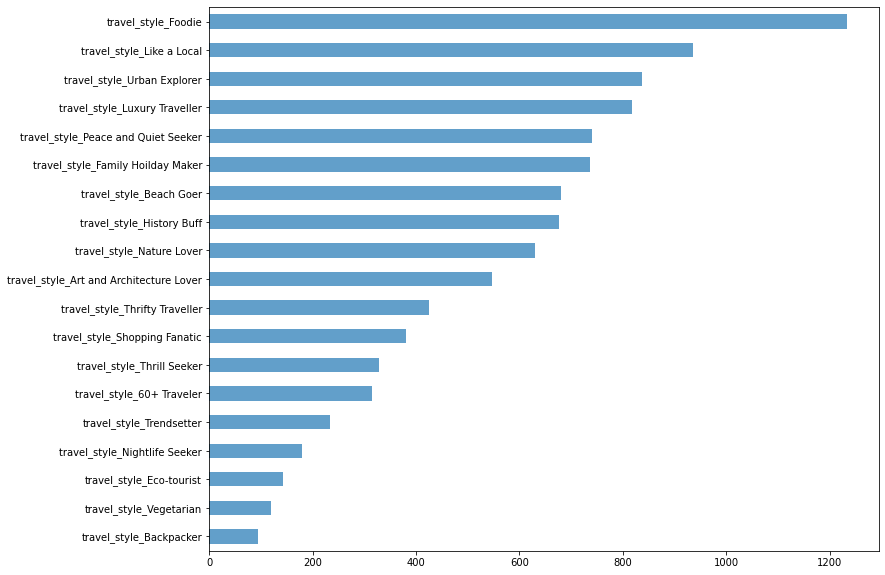

In [ ]:
#Frequency of number of travellers with each travel style
(travel_style_matrix.sum(axis=0)
                   .sort_values(ascending=True)
                   .plot(kind='barh',
                         figsize=(12,10),
                         alpha = .7));

# data 1 - personality scores

In [ ]:
New_data1 = data1.drop(['username'], axis = 1);
New_data1.head()

,open,cons,extra,agree,neuro
0,0.63272,0.55666,0.56360,0.58108,0.45881
1,0.64006,0.55189,0.56220,0.57943,0.46188
2,0.66435,0.56099,0.56880,0.58187,0.45011
3,0.66003,0.57005,0.57221,0.59019,0.44860
4,0.65036,0.55429,0.56510,0.58271,0.45919


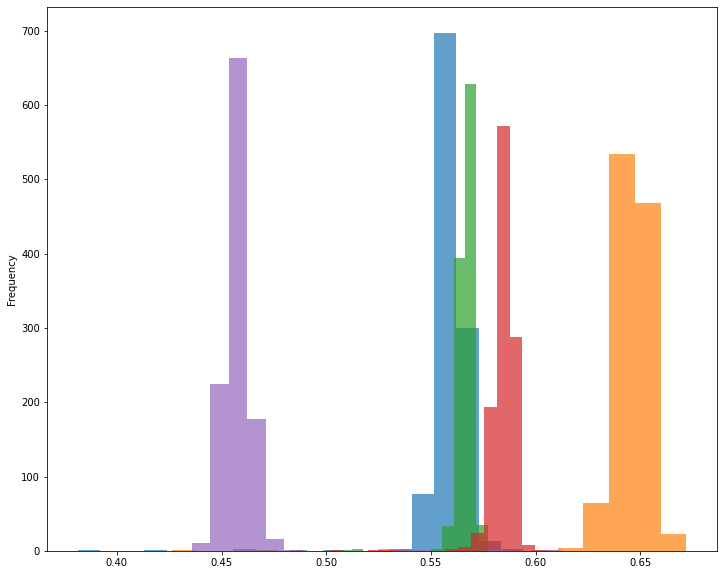

In [ ]:

New_data1['cons'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
New_data1['open'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
New_data1['extra'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
New_data1['agree'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
New_data1['neuro'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);


**merging data1 - personality and data3-reviews**

In [ ]:
#Merging data1 and data3 based on username
data1_merge_3 = pd.merge(data1, filtered_data3, on=['username'])
data1_merge_3.head(2)

,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes,new_travel
0,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12,"[Foodie, Nature Lover, Urban Explorer]"
1,14beacon,0.64359,0.56584,0.56965,0.59001,0.45454,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",...,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14,"[Foodie, Trendsetter, Like a Local, Luxury Tra..."


In [ ]:

final_table = pd.merge(data1_merge_3, data4, on=['username'])
final_table.head(2)


,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-09-28,Unhygienic & terrible service,I have visited this restaurant twice before an...,1,0.0,100,Wahaca Bristol,http://www.tripadvisor.com/Restaurant_Review-g...,Bristol
1,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-06-30,Beautiful resturant overlooking the beach and ...,If you are in Alvor you must visit Canico! Bea...,5,1.0,101,Canico Restaurant,http://www.tripadvisor.com/Restaurant_Review-g...,Alvor


In [ ]:
final_table.type.unique()

array(['Restaurants', 'Hotels', 'Attractions'], dtype=object)

In [ ]:
attra_mask_final = final_table.type == 'Attractions'

In [ ]:
final_table_2 = final_table[attra_mask_final]

In [ ]:

final_table_2.columns.values

array(['username', 'open', 'cons', 'extra', 'agree', 'neuro', 'ageRange',
       'gender', 'location', 'travelStyle', 'reviewerBadge',
       'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes', 'new_travel', 'id', 'type',
       'date', 'title', 'text', 'rating', 'helpfulness', 'total_points',
       'taObject', 'taObjectUrl', 'taObjectCity'], dtype=object)

In [ ]:
final_table_2.shape

(2637, 36)

# 109 cities have more than 4 reviews

In [ ]:
popular_city = []
for item, value in Counter(final_table_2.taObjectCity).items():
    if value > 4:
        popular_city.append(item)
len(popular_city)
print(popular_city)


['Berlin', 'London', 'Kuala Lumpur', 'Brussels', 'Darwin', 'Chattanooga', 'St. Petersburg', 'Vienna', 'Athens', 'Granada', 'Barcelona', 'Madrid', 'Canberra', 'Washington DC', 'New York City', 'Montreal', 'Budapest', 'Santa Barbara', 'Sydney', 'Hanoi', 'Rome', 'Nashville', 'San Francisco', 'Dubai', 'Calgary', 'Quebec City', 'Chicago', 'Orlando', 'Anaheim', 'Lucerne', 'Amsterdam', 'Honolulu', 'Cologne', 'Paris', 'Monterey', 'Las Vegas', 'Boston', 'Yellowstone National Park', 'Bangkok', 'Lahaina', 'Helsinki', 'Hong Kong', 'Munich', 'Singapore', 'Vatican City', 'San Juan', 'Stratford-upon-Avon', 'Niagara Falls', 'Florence', 'Tallinn', 'Nice', 'Oxford', 'Reykjavik', 'Bergen', 'Venice', 'Key West', 'Atlanta', 'Miami', 'Los Angeles', 'Edinburgh', 'Belfast', 'Minato', 'Seattle', 'Brighton', 'Sentosa Island', 'Sao Paulo', 'Rio de Janeiro', 'Buenos Aires', 'Prague', 'Istanbul', 'Oslo', 'Manchester', 'Salzburg', 'Toronto', 'Naples', 'Lancaster', 'Moscow', 'Milan', 'Monte-Carlo', 'Hoi An', 'Warsaw

In [ ]:
final_table_3 = final_table_2[final_table_2.taObjectCity.isin(popular_city)]

In [ ]:
final_table_3 = final_table_3.reset_index()
final_table_3.head()

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


# ALS model - creating spark dataframe

In [ ]:
#Installing findspark
!pip install -q findspark

In [ ]:
import findspark
findspark.init() 

In [ ]:
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
SparkSession.builder.config(conf=SparkConf())


In [ ]:
# Building our Spark Session and Context

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc
sqlContext = SQLContext(sc)


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
final_table_3.head()


,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


In [ ]:
RDD = final_table_3[['username', 'taObjectCity', 'rating']]
RDD


,username,taObjectCity,rating
0,19Cam,Berlin,4
1,19Cam,Berlin,3
2,19Cam,London,5
3,19Cam,Kuala Lumpur,4
4,19Cam,Brussels,3
...,...,...,...
1269,FamilyTravelJunkkie,Bridgetown,4
1270,FamilyTravelJunkkie,Miami,2
1271,Farnborough,Berlin,1
1272,Farnborough,Amsterdam,1


In [ ]:
len(RDD.username.unique())

234

**creating user dictionary with key = user, values = id/index**

In [ ]:

user_dict = {}
for idx, user in enumerate(RDD.username.unique()):
    user_dict[user] = idx
    
user_dict;

In [ ]:

user_id_list = [user_dict[item] 
                  for user in RDD.username for item, key in user_dict.items() 
                  if item == user]


In [ ]:
RDD['user_id'] = user_id_list


<ipython-input-159-7ba7bd80370c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RDD['user_id'] = user_id_list


In [ ]:
RDD.head(10)

,username,taObjectCity,rating,user_id
0,19Cam,Berlin,4,0
1,19Cam,Berlin,3,0
2,19Cam,London,5,0
3,19Cam,Kuala Lumpur,4,0
4,19Cam,Brussels,3,0
5,1Angie,Darwin,5,1
6,1Angie,Darwin,2,1
7,1Angie,Darwin,4,1
8,1Angie,Darwin,5,1
9,1Angie,Darwin,3,1


In [ ]:
len(user_id_list) == len(RDD.username)

True

In [ ]:
len(RDD.taObjectCity.unique())

109

**creating city dictionary with key = city, values =id/index**

In [ ]:
city_dictionary = {}
for idx, city in enumerate(RDD.taObjectCity.unique()):
    city_dictionary[city] = idx
    
city_dictionary;


In [ ]:

city_id_list_2 = [city_dictionary[item] for city in RDD.taObjectCity 
                  for item, key in city_dictionary.items() if item == city]


In [ ]:
# making sure each city has an id

len(RDD.taObjectCity) == len(city_id_list_2)

True

In [ ]:
RDD.head(10)


,username,taObjectCity,rating,user_id
0,19Cam,Berlin,4,0
1,19Cam,Berlin,3,0
2,19Cam,London,5,0
3,19Cam,Kuala Lumpur,4,0
4,19Cam,Brussels,3,0
5,1Angie,Darwin,5,1
6,1Angie,Darwin,2,1
7,1Angie,Darwin,4,1
8,1Angie,Darwin,5,1
9,1Angie,Darwin,3,1


In [ ]:

RDD['city_id'] = city_id_list_2

<ipython-input-168-0cc29b894285>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RDD['city_id'] = city_id_list_2


In [ ]:
new_RDD = RDD[['user_id', 'city_id', 'rating']]
new_RDD['rating_float'] = pd.to_numeric(new_RDD.rating, downcast='float');
new_RDD['rating_float']


<ipython-input-169-7e6e6e49f576>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_RDD['rating_float'] = pd.to_numeric(new_RDD.rating, downcast='float');


0       4.0
1       3.0
2       5.0
3       4.0
4       3.0
       ... 
1269    4.0
1270    2.0
1271    1.0
1272    1.0
1273    2.0
Name: rating_float, Length: 1274, dtype: float32

In [ ]:
new_RDD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       1274 non-null   int64  
 1   city_id       1274 non-null   int64  
 2   rating        1274 non-null   int64  
 3   rating_float  1274 non-null   float32
dtypes: float32(1), int64(3)
memory usage: 35.0 KB


In [ ]:
new_new_RDD = new_RDD[['user_id','city_id','rating_float']]

In [ ]:
new_new_RDD.head()


,user_id,city_id,rating_float
0,0,0,4.0
1,0,0,3.0
2,0,1,5.0
3,0,2,4.0
4,0,3,3.0


In [ ]:
schema = StructType( [ 
    StructField('user', IntegerType(), True),
    StructField('city', IntegerType(), True),
    StructField('rating', FloatType(), True)]
)


In [ ]:
sp_df = sqlContext.createDataFrame(new_new_RDD, schema)
sp_df.take(10)


[Row(user=0, city=0, rating=4.0),
 Row(user=0, city=0, rating=3.0),
 Row(user=0, city=1, rating=5.0),
 Row(user=0, city=2, rating=4.0),
 Row(user=0, city=3, rating=3.0),
 Row(user=1, city=4, rating=5.0),
 Row(user=1, city=4, rating=2.0),
 Row(user=1, city=4, rating=4.0),
 Row(user=1, city=4, rating=5.0),
 Row(user=1, city=4, rating=3.0)]

In [ ]:
type(sp_df)


pyspark.sql.dataframe.DataFrame

In [ ]:
train, test = sp_df.randomSplit([0.8, 0.2], seed=427471138)
train.show(10);


+----+----+------+
|user|city|rating|
+----+----+------+
|   0|   0|   3.0|
|   0|   0|   4.0|
|   0|   1|   5.0|
|   0|   2|   4.0|
|   0|   3|   3.0|
|   1|   4|   3.0|
|   1|   4|   4.0|
|   1|   4|   5.0|
|   1|   4|   5.0|
|   2|   5|   5.0|
+----+----+------+
only showing top 10 rows



**ALS model**

In [ ]:
ALS_model = ALS(userCol='user',
                itemCol='city',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=20
               )

In [ ]:
recommender = ALS_model.fit(train)
recommender

ALSModel: uid=ALS_d426c94d26f9, rank=20

In [ ]:
prediction = recommender.transform(test)

In [ ]:
prediction.show(10)


+----+----+------+----------+
|user|city|rating|prediction|
+----+----+------+----------+
|   3|   1|   4.0|  3.971074|
|   6|  20|   5.0| 3.3381014|
|   7|   5|   5.0|  3.144138|
|   7|   5|   5.0|  3.144138|
|   6|  19|   4.0| 3.8367233|
|   1|   4|   2.0|  4.193622|
|   3|  10|   4.0|  4.083082|
|   5|  10|   5.0| 4.8863177|
|   3|  11|   4.0| 3.9959145|
|   3|  11|   5.0| 3.9959145|
+----+----+------+----------+
only showing top 10 rows



In [ ]:
col = prediction.rating-prediction.prediction

In [ ]:
df_pred = prediction.toPandas()
df_pred


,user,city,rating,prediction
0,31,22,5.0,3.122474
1,65,10,5.0,4.199251
2,65,13,5.0,4.538130
3,65,13,5.0,4.538130
4,65,35,5.0,3.500583
...,...,...,...,...
240,186,69,4.0,3.873861
241,174,35,4.0,4.782691
242,180,13,3.0,NaN
243,208,1,5.0,3.689229


In [ ]:
pred = df_pred.prediction
actual = df_pred.rating


In [ ]:
#Calculating the Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, pred.fillna(pred.median()))
print("ALS model''s MSE: ", np.sqrt(mse))


ALS model''s MSE:  1.0277684


# hybrid recommender! - combo of utility matrix and user-only matrix

In [ ]:
travel_style_matrix

,travel_style_60+ Traveler,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,travel_style_Eco-tourist,travel_style_Family Hoilday Maker,travel_style_Foodie,travel_style_History Buff,travel_style_Like a Local,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
7,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0
12,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0
15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0
7028,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0
7029,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
7031,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [ ]:
travel_style_matrix_revised = travel_style_matrix.drop(['travel_style_Foodie', 'travel_style_60+ Traveler'], axis=1)
travel_style_matrix_revised

,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,travel_style_Eco-tourist,travel_style_Family Hoilday Maker,travel_style_History Buff,travel_style_Like a Local,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0
12,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0
15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0
7028,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
7029,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
7031,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [ ]:
df_age_gender = final_table_3[['ageRange', 'gender']]
df_age_gender

,ageRange,gender
0,25-34,male
1,25-34,male
2,25-34,male
3,25-34,male
4,25-34,male
...,...,...
1269,35-49,male
1270,35-49,male
1271,50-64,male
1272,50-64,male


In [ ]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['ageRange'])


In [ ]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['gender'])

In [ ]:
left = df_age_gender
right = travel_style_matrix_revised


In [ ]:

user_feat_df = left.join(right)


In [ ]:
user_feat_df

,ageRange_18-24,ageRange_25-34,ageRange_35-49,ageRange_50-64,ageRange_65+,gender_female,gender_male,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,...,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
0,0,1,0,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0,0,0,0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,0,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,0,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,0,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0,0,1,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1270,0,0,1,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1271,0,0,0,1,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1272,0,0,0,1,0,0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_feat_df.shape

(1274, 24)

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
user_feat_df_T = user_feat_df.T


In [ ]:
user_feat_df = user_feat_df[np.all(np.isfinite(user_feat_df), axis=1)]

In [ ]:
jaccard_score(user_feat_df_T[0], user_feat_df_T[27],pos_label = "PAIDOFF")

ValueError: ignored

# Clustering

In [ ]:
#Removing null age,null gender and null style values in data3 with total trip advisory points>1000
filtered_data3 = data3[data3.totalPoints > 1000][~nullage][~nullgender][~nullstyle]
filtered_data3


<ipython-input-189-e118f2906129>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data3 = data3[data3.totalPoints > 1000][~nullage][~nullgender][~nullstyle]


,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14
12,1975mark,25-34,male,"Huddersfield, United Kingdom","Foodie, Beach Goer, Thrifty Traveller, Nightli...",Senior Contributor,2010-06-01,12.0,15.0,NaN,4.0,NaN,NaN,NaN,NaN,13.0,2718.0,4,18
15,19Cam,25-34,male,"London, United Kingdom","Vegetarian, Urban Explorer, Art and Architectu...",Top Contributor,2010-05-01,58.0,28.0,8.0,NaN,2.0,12.0,1.0,NaN,49.0,9836.0,5,46
17,1Angie,18-24,female,"Melbourne, Australia","Beach Goer, Vegetarian, Urban Explorer",Senior Contributor,2010-08-01,20.0,5.0,8.0,3.0,NaN,11.0,NaN,NaN,18.0,3649.0,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,zohei,50-64,male,"Paris, France","Foodie, Like a Local, Urban Explorer, Luxury T...",Top Contributor,2005-11-01,33.0,42.0,1.0,13.0,1.0,36.0,NaN,NaN,28.0,8731.0,5,46
7028,zotar,35-49,male,UK,"Foodie, Like a Local, Urban Explorer, Family H...",Top Contributor,2006-08-01,28.0,47.0,5.0,10.0,14.0,NaN,33.0,NaN,47.0,8809.0,5,79
7029,zsazsa-stl,35-49,female,"Baltimore, Maryland","Like a Local, Thrifty Traveller, Art and Archi...",Top Contributor,2006-03-01,24.0,34.0,12.0,6.0,15.0,NaN,20.0,NaN,37.0,7499.0,5,24
7031,zulnas,35-49,male,"Singapore, Singapore","Foodie, Thrifty Traveller, Shopping Fanatic",Top Contributor,2006-05-01,38.0,5.0,15.0,12.0,79.0,55.0,40.0,NaN,41.0,8678.0,5,33


In [ ]:

filtered_data3 = filtered_data3[['username']]


In [ ]:
filtered_data4 = data4[['id', 'username', 'type', 'title', 'text', 'rating', 'taObjectCity']]
filtered_data4

,id,username,type,title,text,rating,taObjectCity
0,1,007solotraveler,Hotels,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,Stockholm
1,2,007solotraveler,Hotels,Modern and Chic - suitable both family and bus...,Excellent Hotel - well situated for getting ro...,5,Stockholm
2,3,007solotraveler,Attractions,Brilliant - Well worth a visit(s),Great Museum - abslutely worth making the time...,5,Stockholm
3,4,007solotraveler,Hotels,Family stay,Stayed for 3 nights in MIami - stayed here due...,4,Miami
4,5,007solotraveler,Restaurants,Great Prime Rib!,I always visit Hunters when in San Diego. The ...,5,San Diego
...,...,...,...,...,...,...,...
32575,32616,Farnborough,Restaurants,"Good food, service and location",This restaurant is in a prime location in the ...,4,Haarlem
32576,32617,Farnborough,Restaurants,Sit in the sun watching the world go by,This is a very good cafГ© on the main square i...,5,Haarlem
32577,32618,Farnborough,Restaurants,Eat while watching the sun set,Friendly and helpful staff. They helped us cho...,5,Zandvoort
32578,32619,Farnborough,Hotels,Comfortable base to explore the area,"We stayed in the studio apartment, which compr...",5,Zandvoort


In [ ]:
only_attraction = filtered_data4.type == 'Attractions'
filtered_data4 = filtered_data4[only_attraction]


In [ ]:
#Merging data3 with username column and filtered_data4 based on 'username'
data3_merge_4 = pd.merge(filtered_data4, filtered_data3, on=['username'])
data3_merge_4

,id,username,type,title,text,rating,taObjectCity
0,103,14beacon,Attractions,Better than expected,"Went with my wife, parents, two kids (7) & (12...",5,Charleston
1,104,14beacon,Attractions,Solid Park - Good Bang for the Buck,My family and I just came back from spending a...,4,Farmingdale
2,362,19Cam,Attractions,See it before its gone,The box is only a temporary exhibit while cons...,4,Berlin
3,363,19Cam,Attractions,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,Berlin
4,378,19Cam,Attractions,Fantastic,"After reading all the hype about this show, I ...",5,London
...,...,...,...,...,...,...,...
2632,32580,Farnborough,Attractions,A bit of a joke really,This is not actually the original or genuine C...,1,Berlin
2633,32586,Farnborough,Attractions,I couldn&acute;t believe how bad this place is,At least a third of the stalls are vacant. Of ...,1,Norwich
2634,32588,Farnborough,Attractions,Visit cut short to allow BBC to film,The castle keep and surrounding grounds are wo...,2,Norwich
2635,32612,Farnborough,Attractions,Not worth visiting,"As cat lovers, when we saw this mentioned in o...",1,Amsterdam


In [ ]:
# cities with more than 4 reviews
popular_city = []
for item, value in Counter(data3_merge_4.taObjectCity).items():
    if value > 7:
        popular_city.append(item)
print(len(popular_city))

59


In [ ]:
df_final = data3_merge_4[data3_merge_4.taObjectCity.isin(popular_city)]

In [ ]:
df_final.head()


,id,username,type,title,text,rating,taObjectCity
2,362,19Cam,Attractions,See it before its gone,The box is only a temporary exhibit while cons...,4,Berlin
3,363,19Cam,Attractions,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,Berlin
4,378,19Cam,Attractions,Fantastic,"After reading all the hype about this show, I ...",5,London
5,414,19Cam,Attractions,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,Kuala Lumpur
18,778,1oldseagull,Attractions,THIS SHOULD BE A FIRST STOP,"First thing, this visiter center was not easy ...",5,Chattanooga


In [ ]:

df_final.shape

(991, 7)

# clustering functions

In [ ]:
#Extracting the title,text,city from df_final
cluster_input = df_final.copy()
cluster_input = cluster_input[['title', 'text', 'taObjectCity']]
cluster_input

,title,text,taObjectCity
2,See it before its gone,The box is only a temporary exhibit while cons...,Berlin
3,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",Berlin
4,Fantastic,"After reading all the hype about this show, I ...",London
5,Tranquility in a busy city,Sited within the main botanical gardens area o...,Kuala Lumpur
18,THIS SHOULD BE A FIRST STOP,"First thing, this visiter center was not easy ...",Chattanooga
...,...,...,...
2617,If you travel at the right time there are no c...,Disneyland is great and so is California Adven...,Anaheim
2622,If you are a cricket fan,If you are a cricket fan Kensington Oval is de...,Bridgetown
2632,A bit of a joke really,This is not actually the original or genuine C...,Berlin
2635,Not worth visiting,"As cat lovers, when we saw this mentioned in o...",Amsterdam


In [ ]:
df_title_comb = df_final.groupby(['taObjectCity']).apply(lambda x: ' '.join(x.title)).reset_index()
df_text_comb = df_final.groupby(['taObjectCity']).apply(lambda x: ' '.join(x.text)).reset_index()



In [ ]:

df_text_comb.head()

,taObjectCity,0
0,Amsterdam,We found Van Gogh&acute;s story so interesting...
1,Anaheim,Disney has taken time to build the new cars la...
2,Bangkok,Every Bangkok visit should include the Grand p...
3,Barcelona,"The gardens are very pleasant, but nothing out..."
4,Bergen,A hike that will leave you tired but smiling. ...


In [ ]:
cluster_input = df_title_comb.merge(df_text_comb, on= 'taObjectCity')


In [ ]:

cluster_input.head()

,taObjectCity,0_x,0_y
0,Amsterdam,An interesting Story from start to finish A Mu...,We found Van Gogh&acute;s story so interesting...
1,Anaheim,Cars land a great addition Easy shopping an ol...,Disney has taken time to build the new cars la...
2,Bangkok,Impressive indeed! Must do also :) Nice one - ...,Every Bangkok visit should include the Grand p...
3,Barcelona,OK More than a club Just wow! Cosmo Scooter - ...,"The gardens are very pleasant, but nothing out..."
4,Bergen,A Great Hike! Touristy and Pricey A Must-Do......,A hike that will leave you tired but smiling. ...


In [ ]:
cluster_input.columns = ['taObjectCity','title','text']
cluster_input.head()

,taObjectCity,title,text
0,Amsterdam,An interesting Story from start to finish A Mu...,We found Van Gogh&acute;s story so interesting...
1,Anaheim,Cars land a great addition Easy shopping an ol...,Disney has taken time to build the new cars la...
2,Bangkok,Impressive indeed! Must do also :) Nice one - ...,Every Bangkok visit should include the Grand p...
3,Barcelona,OK More than a club Just wow! Cosmo Scooter - ...,"The gardens are very pleasant, but nothing out..."
4,Bergen,A Great Hike! Touristy and Pricey A Must-Do......,A hike that will leave you tired but smiling. ...


In [ ]:

cluster_input.set_index(['taObjectCity'], drop=True, inplace=True)

In [ ]:

cluster_input.head()

,title,text
taObjectCity,,
Amsterdam,An interesting Story from start to finish A Mu...,We found Van Gogh&acute;s story so interesting...
Anaheim,Cars land a great addition Easy shopping an ol...,Disney has taken time to build the new cars la...
Bangkok,Impressive indeed! Must do also :) Nice one - ...,Every Bangkok visit should include the Grand p...
Barcelona,OK More than a club Just wow! Cosmo Scooter - ...,"The gardens are very pleasant, but nothing out..."
Bergen,A Great Hike! Touristy and Pricey A Must-Do......,A hike that will leave you tired but smiling. ...


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
def cluster_content(content, clusters=3):
    
    #Transform content to Tf-Idf coordinates and cluster content using K-Means 
    
    #my_additional_stop_words = ['acute', 'good', 'great', 'really', 'just', 'nice', 'like', 'day']
    my_additional_stop_words = ['acute', 'good', 'great', 'really', 'just', 'nice', 
                                'like', 'day', 'beautiful', 'visit', 'time', 'don',
                                'did', 'place', 'didn', 'did', 'tour', 'sydney','pm',
                                'lot', '00', 'inside', 'istanbul', 'doesn','going',
                                'right', '15']
    stop_words = ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    
    
    vectorizer = TfidfVectorizer(stop_words= stop_words,
                                 max_features = 400,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(content)
    vectors = tfidf_model.toarray()
    cols = vectorizer.get_feature_names()

    return (vectors, cols)


def cluster(vectors, cols, content):
    
    #Cluster vecotirzed reviews and create k books a data frame relating the k label to the book id
    
    kmeans = KMeans(n_clusters=5, random_state=2929292).fit(vectors)
    k_books = pd.DataFrame(list(zip(list(kmeans.labels_),
                                list(content.index))),
                                columns=['cluster_k', 'city_index'])
    
    # added code to print centriod vocab - Print the top n words from all centroids vocab
    
    n = 20
    centroids = kmeans.cluster_centers_
    for ind, c in enumerate(centroids):
        print(ind)
        indices = c.argsort()[-1:-n-1:-1]
        print([cols[i] for i in indices])
        print("=="*20)
    
    return k_books

In [ ]:
reviews = cluster_input.text
content = [i for i in reviews]
content

['We found Van Gogh&acute;s story so interesting and were able to see it on the screen as well as follow his paintings - all having a story to tell One of the best museums in the world. Tastefully set out with amazing art. We loved this museum and encourage anyone to put it on the top of their list. This is an experience that everyone should see. A girl so young reaching out through her writing to the whole world. We wondered if she would have had any idea that her writing would reach so far and wide. It was a quick checkin to get the tickets and off we were in the building. A lot of concrete walls and stuff first - a little boring. Then we entered big room with brewing boilers etc. which was much more interesting. Then a ride on Heineken Experience, tasting beer, some fun with recording videos, photos and sending them to our friends -> to the bar for free 2 glasses/person and my wife doesn&acute;t drink beer -> so 4 for me :) And we were through! Expensive shop at the end, but we got 

In [ ]:
vector, cols = cluster_content(content, 5)
cluster_df = cluster(vector, cols, reviews)

0
['museum', 'history', 'interesting', 'guide', 'building', 'hours', 'worth', 'main', 'city', 'walk', 'took', 'free', 'small', 'bus', 'fun', 'room', 'experience', 'tickets', 'boat', 'look']
1
['worth', 'bar', 'bay', 'free', 'hotel', 'food', 'restaurant', 'drinks', 'area', 'minutes', 'city', 'fun', 'vegas', 'money', 'walk', 'trip', 'gardens', 'para', 'view', 'experience']
2
['trail', 'falls', 'hike', 'parking', 'road', 'memorial', 'area', 'water', 'walk', 'views', 'worth', 'drive', 'ride', 'view', 'bear', 'beach', 'wait', 'easy', 'way', 'minutes']
3
['town', 'old', 'train', 'ship', 'walk', 'central', 'plenty', 'work', 'best', 'bridge', 'busy', 'areas', 'enjoyed', '20', 'guided', 'market', 'worth', 'opportunities', 'close', 'loved']
4
['people', 'park', 'fun', 'went', 'museum', 'food', 'worth', 'little', 'way', 'experience', 'art', 'view', 'music', 'recommend', 'amazing', 'love', 'city', 'tourists', 'lots', 'guide']


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
cluster0 = (cluster_df['cluster_k'] ==0)
cluster1= (cluster_df['cluster_k'] ==1)
cluster2 = (cluster_df['cluster_k'] ==2)
cluster3 = (cluster_df['cluster_k'] ==3)
cluster4 = (cluster_df['cluster_k'] ==4)

In [ ]:
zero_cluster=cluster_df[cluster0]
zero_cluster

,cluster_k,city_index
0,0,Amsterdam
3,0,Barcelona
5,0,Berlin
7,0,Bridgetown
8,0,Budapest
9,0,Chattanooga
12,0,Edinburgh
16,0,Istanbul
19,0,Kyoto
30,0,Munich


In [ ]:
cluster_df[cluster1]

,cluster_k,city_index
11,1,Dubai
13,1,Helsinki
18,1,Kuala Lumpur
21,1,Las Vegas
27,1,Monterey
28,1,Montreal
32,1,New Orleans
45,1,San Francisco
47,1,Singapore
51,1,Sydney


In [ ]:
cluster_df[cluster2]

,cluster_k,city_index
4,2,Bergen
15,2,Honolulu
23,2,Los Angeles
34,2,Niagara Falls
57,2,Yellowstone National Park
58,2,Yosemite National Park


In [ ]:

cluster_df[cluster3]

,cluster_k,city_index
17,3,Key West
24,3,Lucerne
35,3,Nice
49,3,Stockholm


In [ ]:
cluster_df[cluster4]

,cluster_k,city_index
1,4,Anaheim
2,4,Bangkok
6,4,Boston
10,4,Chicago
14,4,Hong Kong
20,4,Lancaster
22,4,London
25,4,Madrid
26,4,Melbourne
29,4,Moscow
